# 5.0 Modelling-ARIMAX

Work book summary:

This work book takes the EUR-USD data and the pattern matches and uses ARIMAX to predict the price of the next few time frames.


Auto arima suggested the best parameters to use would (0,1,0) rather than my expected (1,1,0). This is ok as the graphs are just an estimate and autoarima is more accurate so I used those parameters.

The results were:

Marubuzo:
+ Accuracy:	    0.5
+ Precision:	0.74
+ Recall:		0.34

Fractals:
+ Accuracy:	    0.56
+ Precision:	0.69
+ Recall:		0.63

SARIMAX was not used as the the model cant detect parameters to show seasonality so it wont be used.




---

# Contents
    
- [1.0 About ARIMAX Model](#1.0-About-ARIMAX-Model)
- [2.0 Marubozu](#2.0-Marubozu)
    - [2.1 Load Data](#2.1-Load-Data)
    - [2.2 Check Parameters](#2.2-Check-Parameters)
- [3.0 Model](#3.0-Model)
    - [3.1 Train/Test Split](#3.1-Train/Test-Split)
    - [3.2 Fit Model](#3.2-Fit-Model)
    - [3.3 Calculate Results](#3.3-Calculate-Results)
    - [3.4 Run Model](#3.4-Run-Model)
- [4.0 Results](#4.0-Results)
- [5.0 Fractals](#5.0-Fractals)
    - [5.1 Load Data](#5.1-Load-Data)
- [6.0 Model](#6.0-Model)
    - [6.1 Train/Test Split](#6.1-Train/Test-Split)
    - [6.2 Fit Model](#6.2-Fit-Model)
    - [6.3 Calculate Results](#6.3-Calculate-Results)
    - [6.4 Run Model](#6.4-Run-Model)
- [7.0 Results](#7.0-Results)
- [8.0 SARIMAX](#8.0-SARIMAX)



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import calendar

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA, ARMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score, mean_squared_error
from pmdarima import auto_arima
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tools.eval_measures import rmse


In [2]:
pd.set_option('display.max_columns', None)

---

# 1.0 About ARIMAX Model

The Arima model has 3 components:

+ Differencing Step - I - Integrated - Check for stationarity
+ Autoregressive Piece - AR - long term trends
+ Moving Average Piece - MA - Modelling sudden fluctuations

Each part has input into the model P, D, Q.

+ D is the order of differencing we found using the Augmented Dickey-Fuller test.
+ P is the number of autoregressive terms in our model. PACF is used to estimate this.
+ Q is to do with looking at the moving average.
    + If PACF has a sharp cut off and lag-1 for the ACF is negative choose q to be the lag in the ACF before cut off.
    + If PACF does not have a sharp cut off or lag -1 ACF is not negative choose q = 0

Therefore based on the charts before I will use:
    
    + p = 1
    + d = 1
    + q = 0
    
However I will use auto_arima to help decide.

The X in the model stands for Exogenous features which are external features away from the time frame. The time series models look at time as a key factor. This is accurate when time is a key feature in determining price. For example stock control will be lnked to time as the more time the less stock is liekly.

The FOREX market has a lot of external features which are important to drive the prices. Therefore I added gold price, volatility and 2 Moving Averages. The idea is the model can use the extra information to help predict the price.

---

# 2.0 Marubuzo

## 2.1 Load Data

In [3]:
daily_pattern = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/patterns/dailyMarubozu.csv', 
                           parse_dates=True)

In [4]:
daily = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/data/resampled/eur-usddailyMarubozu.csv', 
                    index_col='date', parse_dates=True)

In [5]:
len(daily_pattern)

64

## 2.2 Check Parameters

In [6]:
### Get correct hyper parameters

In [7]:
## Arima
auto_arima(daily['close'].dropna(), seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4612
Model:               SARIMAX(0, 1, 0)   Log Likelihood               15826.945
Date:                Thu, 06 Aug 2020   AIC                         -31651.890
Time:                        13:06:47   BIC                         -31645.453
Sample:                             0   HQIC                        -31649.624
                               - 4612                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       6.11e-05   5.15e-07    118.588      0.000    6.01e-05    6.21e-05
===================================================================================
Ljung-Box (Q):                       61.33   Jarque-Bera (JB):             20105.01
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

---

# 3.0 Model

## 3.1 Train/Test Split

In [8]:
# create train test split
def create_train_test_split(date, time_series, model_info):

    # Get index of pattern and add 6 (so 5) extra rows for Test/train set
    test_end_loc = time_series.index.get_loc(date) + 6
    
    # Create train/test set using index loc of pattern 
    train_test = time_series.iloc[:test_end_loc]
    
    # Set target values
    target_value = time_series.loc[time_series.index == date,'exit_price'].item()
    
    # add target price to dataset
    train_test.insert(0, 'target_price', target_value)
    
    # Add Signal so it can be determined whether we expect the price to go up or down.
    model_info['signal'] = time_series.loc[date,'marubozu']
    
    # insert the signal to dataset
    train_test.insert(0, 'signal', model_info['signal'])
    
    # create start and end points for the test/train splits
    model_info['start'] = len(train_test)-5
    model_info['end'] = len(train_test)-1
    
    # create the train and data sets
    model_info['train'] = train_test.iloc[:model_info['start']]
    model_info['test'] = train_test.iloc[model_info['start']:]

    return model_info

## 3.2 Fit Model

In [9]:
# Fit the model

def train_arima(model_info, p=0, d=1, q=0):
    
    exog = np.column_stack([model_info['train']['mnth_mv_avg'], 
                            model_info['train']['wk_mv_avg'],
                            model_info['train']['volatility_3_day'],
                            model_info['train']['gold_euro'],
                            model_info['train']['gold_usd']])
    
    if model_info['signal'] == -1:
        model = ARIMA(model_info['train']['low'], exog=exog, order=(p,d,q))
    else:
        model = ARIMA(model_info['train']['high'], exog=exog, order=(p,d,q))

    results = model.fit()
    predictions = results.predict(start=model_info['start'], 
                                  end=model_info['end'], exog=exog,
                                  dynamic=True, 
                                  typ='levels').rename('ARIMA-0-1-0 Predictions')
    
    return results, predictions

## 3.3 Calculate Results

In [10]:
# Determine whether the signal is correct and the future price is surpassed

def meet_threshold(row):
    if row['signal'] == -1 and row['low'] <= row['target_price']:
        return -1
    elif row['signal'] == 1 and row['high'] >= row['target_price']:
        return 1    
    else:
        return 0

In [11]:
# Calculate whether the machine learning model predicted correctly

def ml_decision(row):
    if row['direction'] == -1 and row['preds'] <= row['target_price']:
        return -1
    elif row['direction'] == 1 and row['preds'] >= row['target_price']:
        return 1    
    else:
        return 0

In [12]:
# create outcomes dataframe
def create_results_outcomes_dataframe(test, predictions):    
    outcomes = pd.DataFrame()
    outcomes['low'] = test['low']
    outcomes['high'] = test['high']
    outcomes['preds'] = predictions.values
    outcomes['target_price'] = test['target_price']
    outcomes['direction'] = test['signal']
    outcomes['correct_call'] = test.apply(meet_threshold, axis=1)
    return outcomes

In [13]:
# print chart
def print_chart(outcomes):
    if model_info['signal'] == -1:
        outcomes['low'].plot(legend=False, figsize=(12,8))
    else:
        outcomes['high'].plot(legend=False, figsize=(12,8))

    outcomes['preds'].plot(legend=False);
    outcomes['target_price'].plot(legend=False);

In [14]:
# Calculate the results dataframe for RMSE ans MSE

def get_results(model_info):
        
    if model_info['signal'] == -1:
        mse = mean_squared_error(model_info['test']['low'], predictions)
        rmse_res = rmse(model_info['test']['low'], predictions)
    else:
        mse = mean_squared_error(model_info['test']['high'], predictions)
        rmse_res = rmse(model_info['test']['high'], predictions)       
    
    return rmse_res, mse

In [15]:
# Determine the classfication of the machine learning for the confusion matrix
def classify(outcomes):
    
    if max(outcomes['direction']) == 1:
        
        if max(outcomes['correct_call']) == 0 and max(outcomes['ml_correct_call']) == 0:
            return 'tn'
        elif max(outcomes['correct_call']) == 1 and max(outcomes['ml_correct_call']) == 1:
            return 'tp'
        elif max(outcomes['correct_call']) == 0 and max(outcomes['ml_correct_call']) == 1:
            return 'fp'
        elif max(outcomes['correct_call']) == 1 and max(outcomes['ml_correct_call']) == 0:
            return 'fn'
        
    elif max(outcomes['direction']) == -1:
        
        if min(outcomes['correct_call']) == 0 and min(outcomes['ml_correct_call']) == 0:
            return 'tn'
        elif min(outcomes['correct_call']) == -1 and min(outcomes['ml_correct_call']) == -1:
            return 'tp'
        elif min(outcomes['correct_call']) == 0 and min(outcomes['ml_correct_call']) == -1:
            return 'fp'
        elif min(outcomes['correct_call']) == -1 and min(outcomes['ml_correct_call']) == 0:
            return 'fn'
        
    else:
        return 'ERROR'
    

## 3.4 Run Model

In [16]:
# Main function to drive the model

arima_results = []

for match in daily_pattern['pattern_end']:
    
    model_info = {"train":None,"test":None,"start":None,"end":None,"signal":None}

    
    results_dict = {'name':'arima-0-1-0','strategy':'marubozu','date':match,
                   'time_frame':'daily','RMSE':None,
                   'MSE':None, 'classification':None}
    

    model_info = create_train_test_split(match, daily, model_info)

    if len(model_info['train']) < 10:
        continue

    results, predictions = train_arima(model_info)
    

    outcomes = create_results_outcomes_dataframe(model_info['test'], predictions)
    outcomes['ml_correct_call'] = outcomes.apply(ml_decision, axis=1)

    results_dict['RMSE'], results_dict['MSE'] = get_results(model_info)
    results_dict['classification'] = classify(outcomes)

    arima_results.append(results_dict)
    

In [17]:
# Check no errors
def check_no_errors(results_list):
    errors = 0
    for result in arima_results:
        res = result['classification']
        if res == 'ERROR':
            errors+=1
    
    if errors == 0:
        print("All patterns recorded correctly")
    elif errors > 0:
        print(f"Warning: there were {errors} errors recorded")

In [18]:
check_no_errors(arima_results)

All patterns recorded correctly


---

# 4.0 Results

In [19]:
def create_cm(arima_results):
    
    res_cm = [[0,0],
              [0,0]]
    
    for result in arima_results:
        res = result['classification']
        
        if res == 'tp':
            res_cm[0][0] += 1
        elif res == 'fp':
            res_cm[0][1] += 1
        elif res == 'fn':
            res_cm[1][0] += 1
        elif res == 'tn':
            res_cm[1][1] += 1
    
    return res_cm

In [20]:
cm = create_cm(arima_results)

In [21]:
cm_df = pd.DataFrame(cm, index=['pred_success', 'pred_non_success'], columns=['actual success', 'actual non_success'])
cm_df

,actual success,actual non_success
pred_success,14,5
pred_non_success,27,18


In [22]:
def print_metrics(cm):
    # Accuracy - how many did the model get right
    # Total number of correct predictions / total number of predictions
    acc= (cm[0][0]+cm[1][1])/(np.sum(cm))
    
    # Precision proportion of positive identifications that were actually correct
    # True positives/ true positives + false positives)
    prec = cm[0][0]/(cm[0][0]+cm[0][1])
    
    # Recall - proportion of actual positives that were correctly defined
    # True positives/ true positives + false negatives
    rec = cm[0][0]/(cm[0][0]+cm[1][0])

    print(f"Accuracy:\t{round(acc,2)}\nPrecision:\t{round(prec,2)}\nRecall:\t\t{round(rec,2)}")


In [23]:
# Display the results
print_metrics(cm)

Accuracy:	0.5
Precision:	0.74
Recall:		0.34


---

In [24]:
## Graph of an example

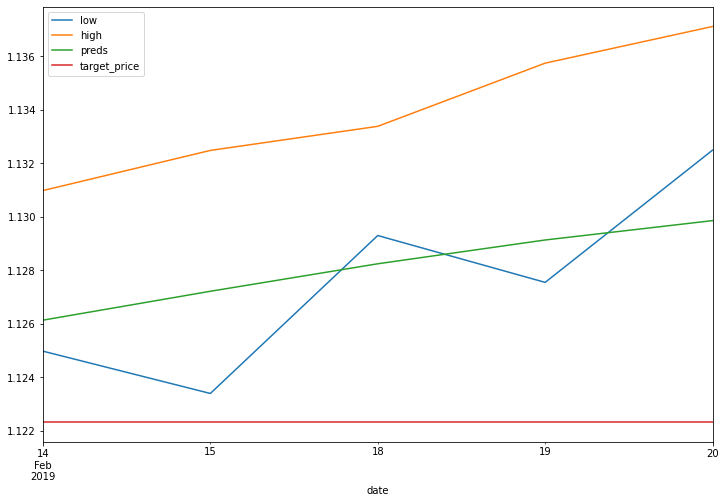

In [25]:
# This shows how the graph will be caluculated
outcomes['low'].plot(legend=True, figsize=(12,8))
outcomes['high'].plot(legend=True)
outcomes['preds'].plot(legend=True);
outcomes['target_price'].plot(legend=True);

In [26]:
arima_results_df = pd.DataFrame(arima_results)
arima_results_df

,name,strategy,date,time_frame,RMSE,MSE,classification
0,arima-0-1-0,marubozu,2000-10-11,daily,0.004065,0.000017,tp
1,arima-0-1-0,marubozu,2000-10-20,daily,0.011222,0.000126,tp
2,arima-0-1-0,marubozu,2001-04-05,daily,0.006349,0.000040,tp
3,arima-0-1-0,marubozu,2001-04-09,daily,0.006417,0.000041,tp
4,arima-0-1-0,marubozu,2001-08-20,daily,0.009487,0.000090,tp
...,...,...,...,...,...,...,...
59,arima-0-1-0,marubozu,2018-09-17,daily,0.004317,0.000019,tp
60,arima-0-1-0,marubozu,2018-10-22,daily,0.012050,0.000145,fn
61,arima-0-1-0,marubozu,2018-12-10,daily,0.008124,0.000066,fn
62,arima-0-1-0,marubozu,2019-01-31,daily,0.009717,0.000094,fn


In [27]:
# Save resutls
arima_results_df.to_csv('/Users/stuartdaw/Documents/Capstone_data/model_results/arima_results_mb.csv', index=False)

---

# 5.0 Fractals

## 5.1 Load Data

In [28]:
daily_fractals = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/data/resampled/eur-usddailyfractals.csv', 
                             index_col='date', parse_dates=True)

In [29]:
fractal_pattern = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/patterns/dailyfractals.csv', 
                           parse_dates=True)

In [30]:
len(fractal_pattern)

613

---

# 6.0 Model

## 6.1 Train/Test Split

In [31]:
# create train test split

def create_train_test_split(date, time_series, model_info):

    # Get index of pattern and add 6 (so 5) extra rows for Test/train set
    test_end_loc = time_series.index.get_loc(date) + 6
    
    # Create train/test set using index loc of pattern 
    train_test = time_series.iloc[:test_end_loc]
    
    # Set target values
    target_value = time_series.loc[time_series.index == date,'exit_price'].item()
    
    # add target price to dataset
    train_test.insert(0, 'target_price', target_value)
    
    # Add Signal so it can be determined whether we expect the price to go up or down.
    model_info['signal'] = time_series.loc[date,'fractal_end']
    
    # insert the signal to dataset
    train_test.insert(0, 'signal', model_info['signal'])
    
    # create start and end points for the test/train splits
    model_info['start'] = len(train_test)-5
    model_info['end'] = len(train_test)-1
    
    # create the train and data sets
    model_info['train'] = train_test.iloc[:model_info['start']]
    model_info['test'] = train_test.iloc[model_info['start']:]

    return model_info

## 6.2 Fit Model

In [32]:
# Fit the model

def train_arima(model_info, p=0, d=1, q=0):
    
    exog = np.column_stack([model_info['train']['mnth_mv_avg'], 
                            model_info['train']['wk_mv_avg'],
                            model_info['train']['volatility_3_day'],
                            model_info['train']['gold_euro'],
                            model_info['train']['gold_usd']])
    
    if model_info['signal'] == -1:
        model = ARIMA(model_info['train']['low'], exog=exog, order=(p,d,q))
    else:
        model = ARIMA(model_info['train']['high'], exog=exog, order=(p,d,q))

    results = model.fit()
    predictions = results.predict(start=model_info['start'], 
                                  end=model_info['end'], exog=exog,
                                  dynamic=True, 
                                  typ='levels').rename('ARIMA-0-1-0 Predictions')
    
    return results, predictions

## 6.3 Calculate Results

In [33]:
# Determine whether the signal is correct and the future price is surpassed

def meet_threshold(row):
    if row['signal'] == -1 and row['low'] <= row['target_price']:
        return -1
    elif row['signal'] == 1 and row['high'] >= row['target_price']:
        return 1    
    else:
        return 0

In [34]:
# Calculate whether the machine learning model predicted correctly

def ml_decision(row):
    if row['direction'] == -1 and row['preds'] <= row['target_price']:
        return -1
    elif row['direction'] == 1 and row['preds'] >= row['target_price']:
        return 1    
    else:
        return 0

In [35]:
# create a dateframe of outcomes

def create_results_outcomes_dataframe(test, predictions):    
    outcomes = pd.DataFrame()
    outcomes['low'] = test['low']
    outcomes['high'] = test['high']
    outcomes['preds'] = predictions.values
    outcomes['target_price'] = test['target_price']
    outcomes['direction'] = test['signal']
    outcomes['correct_call'] = test.apply(meet_threshold, axis=1)
    return outcomes

In [36]:
# print chart to show whats happening

def print_chart(outcomes):
    if model_info['signal'] == -1:
        outcomes['low'].plot(legend=False, figsize=(12,8))
    else:
        outcomes['high'].plot(legend=False, figsize=(12,8))

    outcomes['preds'].plot(legend=False);
    outcomes['target_price'].plot(legend=False);

In [37]:
# Calculate the results dataframe for RMSE ans MSE

def get_results(model_info):
        
    if model_info['signal'] == -1:
        mse = mean_squared_error(model_info['test']['low'], predictions)
        rmse_res = rmse(model_info['test']['low'], predictions)
    else:
        mse = mean_squared_error(model_info['test']['high'], predictions)
        rmse_res = rmse(model_info['test']['high'], predictions)       
    
    return rmse_res, mse

In [38]:
# Determine the classfication of the machine learning for the confusion matrix

def classify(outcomes):
    
    if max(outcomes['direction']) == 1:
        
        if max(outcomes['correct_call']) == 0 and max(outcomes['ml_correct_call']) == 0:
            return 'tn'
        elif max(outcomes['correct_call']) == 1 and max(outcomes['ml_correct_call']) == 1:
            return 'tp'
        elif max(outcomes['correct_call']) == 0 and max(outcomes['ml_correct_call']) == 1:
            return 'fp'
        elif max(outcomes['correct_call']) == 1 and max(outcomes['ml_correct_call']) == 0:
            return 'fn'
        
    elif max(outcomes['direction']) == -1:
        
        if min(outcomes['correct_call']) == 0 and min(outcomes['ml_correct_call']) == 0:
            return 'tn'
        elif min(outcomes['correct_call']) == -1 and min(outcomes['ml_correct_call']) == -1:
            return 'tp'
        elif min(outcomes['correct_call']) == 0 and min(outcomes['ml_correct_call']) == -1:
            return 'fp'
        elif min(outcomes['correct_call']) == -1 and min(outcomes['ml_correct_call']) == 0:
            return 'fn'
        
    else:
        return 'ERROR'
    

## 6.4 Run Model

In [39]:
# Main function to drive the model

arima_results = []

for match in fractal_pattern['pattern_end']:
    
    model_info = {"train":None,"test":None,"start":None,"end":None,"signal":None}

    
    results_dict = {'name':'arima-0-1-0','strategy':'fractals','date':match,
                   'time_frame':'daily','RMSE':None,
                   'MSE':None, 'classification':None}
    

    model_info = create_train_test_split(match, daily_fractals, model_info)

    if len(model_info['train']) < 10:
        continue

    results, predictions = train_arima(model_info)
    

    outcomes = create_results_outcomes_dataframe(model_info['test'], predictions)
    outcomes['ml_correct_call'] = outcomes.apply(ml_decision, axis=1)

    results_dict['RMSE'], results_dict['MSE'] = get_results(model_info)
    results_dict['classification'] = classify(outcomes)

#     print(results_dict['classification'])
#     print(outcomes)
    arima_results.append(results_dict)
    

In [40]:
# Check no errors
def check_no_errors(results_list):
    errors = 0
    for result in arima_results:
        res = result['classification']
        if res == 'ERROR':
            errors+=1
    
    if errors == 0:
        print("All patterns recorded correctly")
    elif errors > 0:
        print(f"Warning: there were {errors} errors recorded")

In [41]:
check_no_errors(arima_results)

All patterns recorded correctly


---

# 7.0 Results

In [42]:
# Create a confusion matrix 

def create_cm(arima_results):
    
    res_cm = [[0,0],
              [0,0]]
    
    for result in arima_results:
        res = result['classification']
        
        if res == 'tp':
            res_cm[0][0] += 1
        elif res == 'fp':
            res_cm[0][1] += 1
        elif res == 'fn':
            res_cm[1][0] += 1
        elif res == 'tn':
            res_cm[1][1] += 1
    
    return res_cm

In [43]:
# Use the results and create a confusion matrix

cm = create_cm(arima_results)

In [44]:
# create a dataframe with the results

cm_df = pd.DataFrame(cm, index=['pred_success', 'pred_non_success'], columns=['actual success', 'actual non_success'])
cm_df

,actual success,actual non_success
pred_success,259,116
pred_non_success,151,86


In [45]:
def print_metrics(cm):
    # Accuracy - how many did the model get right
    # Total number of correct predictions / total number of predictions
    acc= (cm[0][0]+cm[1][1])/(np.sum(cm))
    
    # Precision proportion of positive identifications that were actually correct
    # True positives/ true positives + false positives)
    prec = cm[0][0]/(cm[0][0]+cm[0][1])
    
    # Recall - proportion of actual positives that were correctly defined
    # True positives/ true positives + false negatives
    rec = cm[0][0]/(cm[0][0]+cm[1][0])

    print(f"Accuracy:\t{round(acc,2)}\nPrecision:\t{round(prec,2)}\nRecall:\t\t{round(rec,2)}")


In [46]:
# Display the results
print_metrics(cm)

Accuracy:	0.56
Precision:	0.69
Recall:		0.63


In [47]:
# Graph of an example

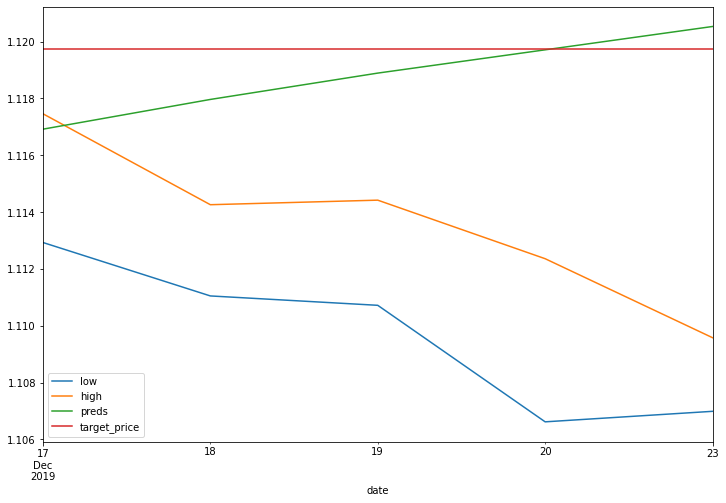

In [48]:
# This shows how the graph will be caluculated

outcomes['low'].plot(legend=True, figsize=(12,8))
outcomes['high'].plot(legend=True)
outcomes['preds'].plot(legend=True);
outcomes['target_price'].plot(legend=True);


In [49]:
arima_results_df = pd.DataFrame(arima_results)
arima_results_df

,name,strategy,date,time_frame,RMSE,MSE,classification
0,arima-0-1-0,fractals,2000-07-28,daily,0.006366,0.000041,tn
1,arima-0-1-0,fractals,2000-08-07,daily,0.014373,0.000207,tp
2,arima-0-1-0,fractals,2000-08-22,daily,0.014946,0.000223,fn
3,arima-0-1-0,fractals,2000-08-29,daily,0.012192,0.000149,fn
4,arima-0-1-0,fractals,2000-09-04,daily,0.017059,0.000291,tp
...,...,...,...,...,...,...,...
607,arima-0-1-0,fractals,2019-10-03,daily,0.001674,0.000003,tn
608,arima-0-1-0,fractals,2019-10-23,daily,0.004562,0.000021,fp
609,arima-0-1-0,fractals,2019-11-18,daily,0.005665,0.000032,fn
610,arima-0-1-0,fractals,2019-11-20,daily,0.007602,0.000058,fp


In [50]:
# Save resutls
arima_results_df.to_csv('/Users/stuartdaw/Documents/Capstone_data/model_results/arima_results_fr.csv', index=False)

# 8.0 SARIMAX

In [52]:
daily.index

DatetimeIndex(['2000-07-14', '2000-07-17', '2000-07-18', '2000-07-19',
               '2000-07-20', '2000-07-21', '2000-07-24', '2000-07-25',
               '2000-07-26', '2000-07-27',
               ...
               '2019-12-11', '2019-12-12', '2019-12-13', '2019-12-16',
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24'],
              dtype='datetime64[ns]', name='date', length=4612, freq=None)

In [53]:
daily['close'].dropna(inplace=True)

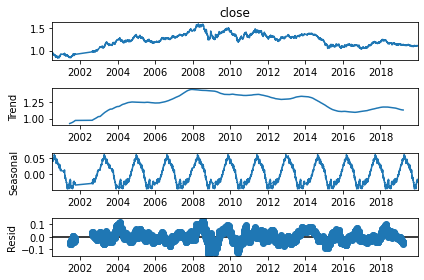

In [54]:
result = seasonal_decompose(daily['close'], model='add', period=400 )
result.plot();

#### I tried the auto_arima function below however it crashes out after several hours 

In [56]:
# %%time
# auto_arima(daily['close'], seasonal=True, maxiter=10000).summary()

So I will try a manual gridsearch

In [58]:
# Starting MSE and (P, D, Q).
mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            try:
                # Instantiate SARIMA model.
                sarima = SARIMAX(endog = daily['close'],
                                 order = (0, 1, 0),              # (p, d, q)
                                 seasonal_order = (P, D, Q, 12)) # (P, D, Q, S)

                # Fit SARIMA model.
                model = sarima.fit()

                # Generate predictions based on training set.
                # Start at time period 0 and end at 1028.
                preds = model.predict(start=0, end=1028)

                # Evaluate predictions.
                print(f'The MSE for (1, 0, 0)x({P},{D},{Q},420) is: {mean_squared_error(train["close"], preds)}')
                
                # Save for final report.
                if mse > mean_squared_error(daily['close'], preds):
                    mse = mean_squared_error(daily['close'], preds)
                    final_P = P
                    final_D = D
                    final_Q = Q
                
            except:
                print(f"p: {P}, D: {D}, Q: {Q}")
                pass

print(f'Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x({final_P},{final_D},{final_Q},420).')
print(f'This model has an MSE of {mse}.')

p: 0, D: 0, Q: 0
p: 0, D: 1, Q: 0
p: 0, D: 2, Q: 0
p: 0, D: 0, Q: 1
p: 0, D: 1, Q: 1
p: 0, D: 2, Q: 1
p: 0, D: 0, Q: 2
p: 0, D: 1, Q: 2
p: 0, D: 2, Q: 2
p: 1, D: 0, Q: 0
p: 1, D: 1, Q: 0
p: 1, D: 2, Q: 0
p: 1, D: 0, Q: 1
p: 1, D: 1, Q: 1
p: 1, D: 2, Q: 1
p: 1, D: 0, Q: 2
p: 1, D: 1, Q: 2
p: 1, D: 2, Q: 2
p: 2, D: 0, Q: 0
p: 2, D: 1, Q: 0
p: 2, D: 2, Q: 0
p: 2, D: 0, Q: 1
p: 2, D: 1, Q: 1
p: 2, D: 2, Q: 1
p: 2, D: 0, Q: 2
p: 2, D: 1, Q: 2
p: 2, D: 2, Q: 2
Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x(0,0,0,420).
This model has an MSE of 990000000000000000.


#### Observation

After several changes to the forecast prices it still doesnt improve the model. So I will assume that seasonality is to small to improve the accuracy of foreacasts and I will stick to ARIMAX.